# Carga del dataset

In [1]:
!rm -rf Ferreyra_Tomas_tp_dt
!git clone https://github.com/tferreyragthb/Ferreyra_Tomas_tp_dt.git

# ================================
# 2. Agregar tu repo al PYTHONPATH
# ================================
import sys
import os

repo_path = "/content/Ferreyra_Tomas_tp_dt"
if repo_path not in sys.path:
    sys.path.append(repo_path)

print("Repo clonado y agregado al PYTHONPATH.")
print(sys.path)


Cloning into 'Ferreyra_Tomas_tp_dt'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 241 (delta 0), reused 0 (delta 0), pack-reused 236 (from 1)
Receiving objects: 100% (241/241), 7.62 MiB | 15.82 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Repo clonado y agregado al PYTHONPATH.
['/content', '/env/python', '/usr/lib/python312.zip', '/usr/lib/python3.12', '/usr/lib/python3.12/lib-dynload', '', '/usr/local/lib/python3.12/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.12/dist-packages/IPython/extensions', '/root/.ipython', '/content/Ferreyra_Tomas_tp_dt']


In [2]:
from src.data.load_data import load_train, load_test
from src.data.preprocessing import normalize_item_ids, create_dt_dataset


In [3]:
import inspect
print(inspect.getsource(create_dt_dataset))


def create_dt_dataset(df_train, save_path="data/processed/trajectories_train.pkl"):
    """
    Convierte el DataFrame crudo al formato Decision Transformer.

    Cada usuario produce UNA trayectoria:

        {
            'items': ndarray(int64),
            'ratings': ndarray(float32),
            'returns_to_go': ndarray(float32),
            'timesteps': ndarray(int64),
            'user_group': int
        }
    """

    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    trajectories = []

    for _, row in df_train.iterrows():
        items = row["items"].astype(np.int64)
        ratings = row["ratings"].astype(np.float32)
        group = int(row["user_group"])

        n = len(items)

        # === returns-to-go acumulado hacia adelante ===
        returns = np.zeros(n, dtype=np.float32)
        returns[-1] = ratings[-1]

        for t in range(n - 2, -1, -1):
            returns[t] = ratings[t] + returns[t + 1]

        timesteps = np.arange(n, dtype=np.int64)

      

In [4]:
import os

# Creo la estructura de carpetas
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/test_users", exist_ok=True)
os.makedirs("data/groups", exist_ok=True)

print("📂 Carpetas creadas")

# ------------------------------------------------------------
# URLs base del repo
# ------------------------------------------------------------
BASE = "https://raw.githubusercontent.com/DiploDatos/AprendizajePorRefuerzos/master/tp_decision_transformer/data"

# ------------------------------------------------------------
# Archivos de TRAIN
# ------------------------------------------------------------
train_files = [
    "train/netflix8_train.df",
    "train/netflixM8_train.df",
    "train/goodreads8_train.df",
]

for f in train_files:
    url = f"{BASE}/{f}"
    dest = f"data/{f}"
    print(f"⬇️  Descargando {f} ...")
    os.makedirs(os.path.dirname(dest), exist_ok=True)
    !wget -q "{url}" -O "{dest}"
print("✔️ Train descargado.")

# ------------------------------------------------------------
# Archivos de TEST USERS
# ------------------------------------------------------------
test_files = [
    "test_users/netflix8_test.json",
    "test_users/goodreads8_test.json",
]

for f in test_files:
    url = f"{BASE}/{f}"
    dest = f"data/{f}"
    print(f"⬇️  Descargando {f} ...")
    !wget -q "{url}" -O "{dest}"
print("✔️ Test users descargado.")

# ------------------------------------------------------------
# Archivos de GROUPS
# ------------------------------------------------------------
groups_files = [
    "groups/mu_goodreads8.csv",
    "groups/mu_netflix8.csv",
    "groups/mu_netflixM8.csv",
]

for f in groups_files:
    url = f"{BASE}/{f}"
    dest = f"data/{f}"
    print(f"⬇️  Descargando {f} ...")
    !wget -q "{url}" -O "{dest}"
print("✔️ Groups descargado.")

# ------------------------------------------------------------
# Verificación
# ------------------------------------------------------------
print("\n📁 CONTENIDO FINAL:")
!ls -R data


📂 Carpetas creadas
⬇️  Descargando train/netflix8_train.df ...
⬇️  Descargando train/netflixM8_train.df ...
⬇️  Descargando train/goodreads8_train.df ...
✔️ Train descargado.
⬇️  Descargando test_users/netflix8_test.json ...
⬇️  Descargando test_users/goodreads8_test.json ...
✔️ Test users descargado.
⬇️  Descargando groups/mu_goodreads8.csv ...
⬇️  Descargando groups/mu_netflix8.csv ...
⬇️  Descargando groups/mu_netflixM8.csv ...
✔️ Groups descargado.

📁 CONTENIDO FINAL:
data:
groups	processed  test_users  train

data/groups:
mu_goodreads8.csv  mu_netflix8.csv  mu_netflixM8.csv

data/processed:
actions.pkl  returns_to_go.pkl	states.pkl

data/test_users:
goodreads8_test.json  netflix8_test.json

data/train:
goodreads8_train.df  netflix8_train.df	netflixM8_train.df


In [5]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# IMPORTS CORRECTOS (sin espacios)
from src.data.load_data import load_train, load_test
from src.data.preprocessing import normalize_item_ids, create_dt_dataset

DATASET = "netflix"   # o "goodreads"



# Exploracion del dataset

In [6]:
train_path = f"data/train/{DATASET}8_train.df"
test_path = f"data/test_users/{DATASET}8_test.json"

df_train = pd.read_pickle(train_path)

with open(test_path, "r") as f:
    test_users = json.load(f)

print("Shape de df_train:", df_train.shape)
print("Cantidad de usuarios de test:", len(test_users))

df_train.head()


Shape de df_train: (16000, 4)
Cantidad de usuarios de test: 1600


,user_id,user_group,items,ratings
0,0,0,"[472, 97, 122, 654, 709, 467, 574, 544, 478, 3...","[4.0, 3.0, 4.0, 3.0, 5.0, 4.0, 2.0, 1.0, 4.0, ..."
1,1,0,"[431, 445, 367, 100, 743, 739, 263, 426, 321, ...","[3.0, 5.0, 5.0, 5.0, 5.0, 3.0, 1.0, 4.0, 5.0, ..."
2,2,0,"[224, 133, 227, 51, 230, 546, 57, 60, 743, 495...","[5.0, 4.0, 3.0, 5.0, 4.0, 3.0, 4.0, 5.0, 5.0, ..."
3,3,0,"[338, 80, 210, 618, 468, 320, 351, 411, 575, 2...","[3.0, 5.0, 3.0, 5.0, 2.0, 1.0, 4.0, 3.0, 3.0, ..."
4,4,0,"[510, 231, 708, 86, 514, 352, 233, 351, 415, 6...","[4.0, 2.0, 3.0, 4.0, 5.0, 4.0, 2.0, 4.0, 3.0, ..."


In [7]:
print("Tipos de datos:\n")
print(df_train.dtypes)


Tipos de datos:

user_id        int64
user_group     int64
items         object
ratings       object
dtype: object


In [8]:
print("Estadísticas descriptivas:\n")
display(df_train.describe())

Estadísticas descriptivas:



,user_id,user_group
count,16000.000000,16000.000000
mean,7999.500000,3.500000
std,4618.946489,2.291359
min,0.000000,0.000000
25%,3999.750000,1.750000
50%,7999.500000,3.500000
75%,11999.250000,5.250000
max,15999.000000,7.000000


# Procesado

In [9]:
mapping, num_items = normalize_item_ids(df_train)

print("Total de ítems:", num_items)
print("Ejemplo de mapeo:", list(mapping.items())[:10])


Total de ítems: 752
Ejemplo de mapeo: [(np.int64(0), 0), (np.int64(1), 1), (np.int64(2), 2), (np.int64(3), 3), (np.int64(4), 4), (np.int64(5), 5), (np.int64(6), 6), (np.int64(7), 7), (np.int64(8), 8), (np.int64(9), 9)]


In [10]:
trajectories_train = create_dt_dataset(
    df_train
)

print(f"Total de trayectorias generadas: {len(trajectories_train)}")
print("Keys de la primera trayectoria:", trajectories_train[0].keys())

✅ Guardado dataset DT en data/processed/trajectories_train.pkl
   Total trayectorias: 16000
Total de trayectorias generadas: 16000
Keys de la primera trayectoria: dict_keys(['items', 'ratings', 'returns_to_go', 'timesteps', 'user_group'])


In [11]:
from pprint import pprint

print("Primera trayectoria:")
pprint(trajectories_train[0])


Primera trayectoria:
{'items': array([472,  97, 122, 654, 709, 467, 574, 544, 478, 338, 301, 185, 156,
       712, 525, 225, 396, 370, 589, 750, 586, 353, 416, 687, 465, 433,
       215, 438, 219, 528, 134, 444,  92,  24, 145, 572,  22, 454, 715,
       364,  19, 115, 386, 374, 203, 229,  44, 624, 303, 152, 206, 268,
       329, 692,   8,  12, 291, 633, 537, 457, 121, 689, 164, 114, 566,
       519, 234, 154, 104,  74,  49,  86, 419, 315, 387, 663, 400]),
 'ratings': array([4., 3., 4., 3., 5., 4., 2., 1., 4., 5., 5., 3., 4., 4., 4., 2., 5.,
       5., 5., 4., 4., 3., 4., 5., 1., 1., 5., 4., 4., 4., 4., 4., 4., 5.,
       2., 4., 5., 3., 4., 3., 2., 1., 5., 3., 4., 4., 3., 5., 4., 5., 4.,
       5., 4., 3., 4., 4., 5., 5., 3., 2., 4., 5., 5., 5., 2., 5., 5., 2.,
       4., 5., 4., 5., 4., 5., 4., 3., 5.], dtype=float32),
 'returns_to_go': array([296., 292., 289., 285., 282., 277., 273., 271., 270., 266., 261.,
       256., 253., 249., 245., 241., 239., 234., 229., 224., 220., 216.,
    

In [12]:
import pickle
import os

processed_dir = "data/processed"
os.makedirs(processed_dir, exist_ok=True)

output_path = os.path.join(processed_dir, f"{DATASET}_trajectories_train.pkl")

with open(output_path, "wb") as f:
    pickle.dump(trajectories_train, f)

print(f"Dataset procesado guardado en: {output_path}")


Dataset procesado guardado en: data/processed/netflix_trajectories_train.pkl


# Graficos

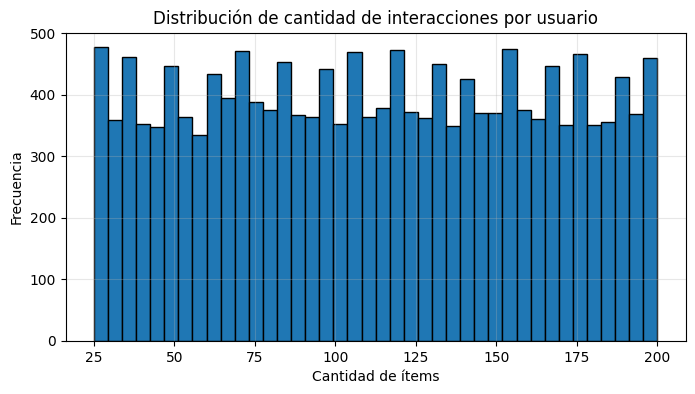

In [13]:
# Cálculo del número de interacciones por usuario
df_train["num_interactions"] = df_train["items"].apply(len)

# Histograma de longitudes
plt.figure(figsize=(8, 4))
plt.hist(df_train["num_interactions"], bins=40, edgecolor="black")
plt.title("Distribución de cantidad de interacciones por usuario")
plt.xlabel("Cantidad de ítems")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()

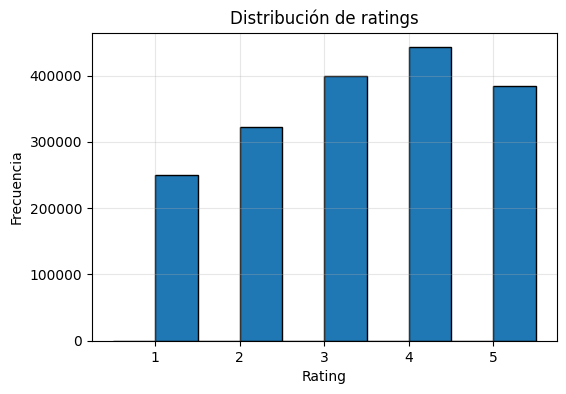

Ratings únicos presentes: [1. 2. 3. 4. 5.]


In [14]:
# Flatten de todos los ratings del dataset
all_ratings = np.concatenate(df_train["ratings"].values)

plt.figure(figsize=(6, 4))
plt.hist(all_ratings, bins=np.arange(0.5, 5.6, 0.5), edgecolor="black")
plt.title("Distribución de ratings")
plt.xlabel("Rating")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()

print("Ratings únicos presentes:", np.unique(all_ratings))


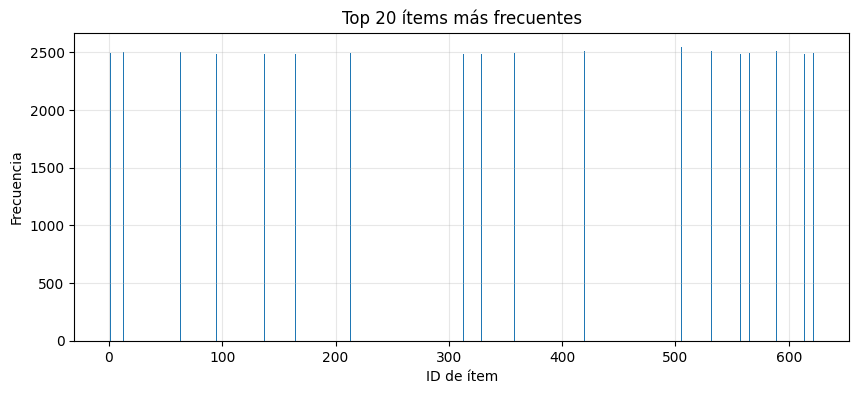

In [16]:
# Conteo de frecuencia de ítems
from collections import Counter

all_items = np.concatenate(df_train["items"].values)
item_counts = Counter(all_items)

# Top 20 ítems más frecuentes
top_items = item_counts.most_common(20)

labels, counts = zip(*top_items)

plt.figure(figsize=(10,4))
plt.bar(labels, counts)
plt.title("Top 20 ítems más frecuentes")
plt.xlabel("ID de ítem")
plt.ylabel("Frecuencia")
plt.grid(alpha=0.3)
plt.show()

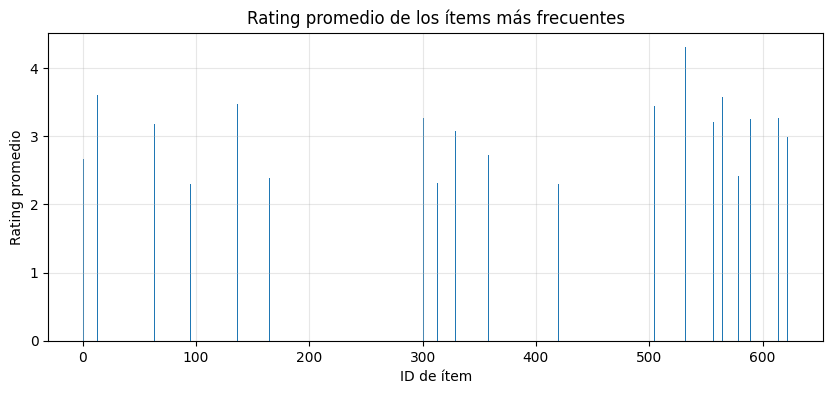

In [17]:
# Ratings promedio de los top 20 ítems más frecuentes

item_ratings_map = {item: [] for item, _ in top_items}

for items, ratings in zip(df_train["items"], df_train["ratings"]):
    for it, rt in zip(items, ratings):
        if it in item_ratings_map:
            item_ratings_map[it].append(rt)

item_means = [np.mean(item_ratings_map[it]) for it in labels]

plt.figure(figsize=(10,4))
plt.bar(labels, item_means)
plt.title("Rating promedio de los ítems más frecuentes")
plt.xlabel("ID de ítem")
plt.ylabel("Rating promedio")
plt.grid(alpha=0.3)
plt.show()